# Using this chapter’s housing dataset:

## Preparing Data

Read the Data with Pandas

In [1]:
import pandas as pd

housing_csv = 'https://github.com/lucaslokchan/ml-journal/raw/master/Learning%20Notes/Chapter%202:%20End-to-End%20Machine%20Learning%20Project/housing.csv'
housing = pd.read_csv(housing_csv)

In [2]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Divide Median Income Into 5 Categories

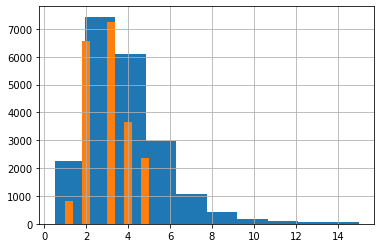

In [3]:
import numpy as np
housing['median_income'].hist()
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].hist()

Perform Stratified Sampling Based on the Income Category

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

Prepare the data for your Machine Learning algorithms

In [5]:
housing = strat_train_set.copy()
housing_labels =strat_train_set['median_house_value'].copy()

Get Rid of ocean_proximity (Non-Numerical Attribute) Since the Median can Only be Computer on Numerical Attributes

In [6]:
housing_num = housing.drop('ocean_proximity', axis=1)

Data Cleaning Pipeline
*   Transform Number Attributes 
*   Convert ocean_proximity with OneHotEncoder



In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),    
        ('std_scaler', StandardScaler()),  
])

full_pipeline = ColumnTransformer([
          ('num', num_pipeline, num_attribs),
          ('cat', OneHotEncoder(), cat_attribs),
])

In [8]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
housing_prepared.shape

(16512, 15)

## 1. Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform? 

### Default Hyperparameter

In [9]:
from sklearn.svm import SVR

sv_reg = SVR()
sv_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Measure the regression model’s RMSE

In [10]:
from sklearn.metrics import mean_squared_error
housing_predictions = sv_reg.predict(housing_prepared)
sv_mse = mean_squared_error(housing_labels, housing_predictions)
sv_rmse = np.sqrt(sv_mse)
sv_rmse

117881.41045362344

Validation Using Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sv_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
sv_rmse_scores = np.sqrt(-scores)

In [12]:
def display_scores(scores):
  print('Scores:', scores)
  print('Mean:', scores.mean())
  print('Standard Deviation:', scores.std())

display_scores(sv_rmse_scores)

Scores: [114175.48176847 117265.95163209 117967.06783805 117659.91195841
 115592.35589696 119279.27149088 117308.84460724 117369.57159962
 125171.39575631 117772.48058512]
Mean: 117956.23331331594
Standard Deviation: 2739.5703948157843


### Different Parameters

In [13]:
sv_reg_1 = SVR(kernel='sigmoid', degree=5, gamma='auto', coef0=0.212, 
               tol=0.5e-3, C=2, epsilon=1.2, shrinking=False, cache_size=200, 
               verbose=True, max_iter=-1)

sv_reg_1.fit(housing_prepared, housing_labels)

[LibSVM]

SVR(C=2, cache_size=200, coef0=0.212, degree=5, epsilon=1.2, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=False, tol=0.0005, verbose=True)

Validation Using Cross-Validation

In [14]:
scores = cross_val_score(sv_reg_1, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
sv_rmse_scores = np.sqrt(-scores)
display_scores(sv_rmse_scores)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Scores: [112296.90079922 115257.77068768 116063.6483537  115744.49336784
 113671.56557168 117290.01565228 115349.69155477 115450.63088488
 123049.79417059 115752.11002813]
Mean: 115992.66210707746
Standard Deviation: 2681.4948518063034


## 2. Try replacing GridSearchCV with RandomizedSearchCV 

Orginial Code Snippet



```
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)
```



In [31]:
from sklearn.model_selection import RandomizedSearchCV

c_values = np.linspace(0, 10, 6)
epsilon_values = np.linspace(0.1, 1.0, 6)

param_grid = [
              {'kernel': ['rbf', 'sigmoid'], 'degree': [1, 2, 3]},
              {'C': c_values, 'epsilon': epsilon_values}
]

sv_reg = SVR()

rand_search = RandomizedSearchCV(sv_reg, param_grid, cv=5,
                                 scoring='neg_mean_squared_error')

rand_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFai

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'degree': [1, 2, 3],
                                         'kernel': ['rbf', 'sigmoid']},
                                        {'C': array([ 0.,  2.,  4.,  6.,  8., 10.]),
                                         'epsilon': array([0.1 , 0.28, 0.46, 0.64, 0.82, 1.  ])}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

Show Best Parameters

In [32]:
rand_search.best_params_

{'C': 10.0, 'epsilon': 0.1}

Show Best Estimator

In [33]:
rand_search.best_estimator_

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## 3. Try adding a transformer in the preparation pipeline to select only the most important attributes.

## 4. Try creating a single pipeline that does the full data preparation plus the final prediction.

## 5. Automatically explore some preparation options using GridSearchCV